## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


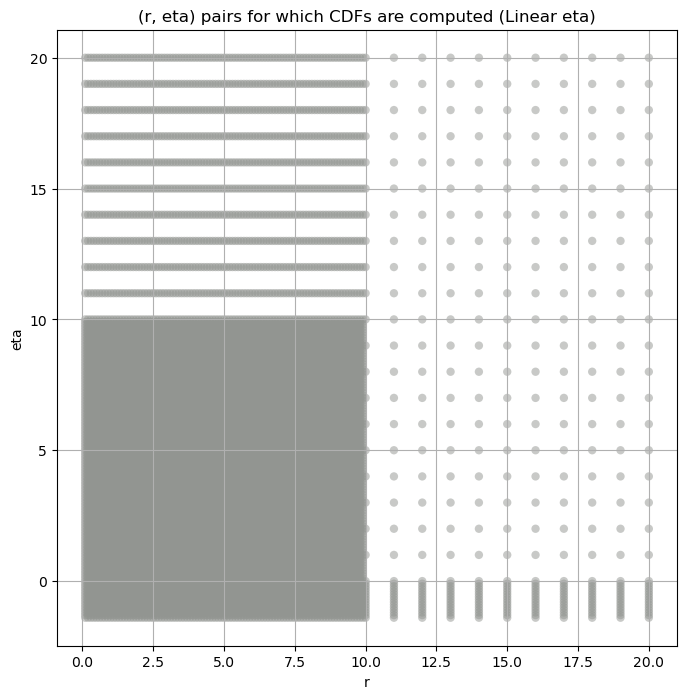

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188568.480000  99639.690000  330252.970000   536.04070  113.300850   
3       42567.688000  23775.207000   71603.100000   488.98392  135.977050   
4       10773.024000   5322.706500   20877.057000   785.26250  131.367690   
5        1800.432600    923.804400    3624.768300   858.10016  109.904150   
6         390.868230    183.293870     971.229200  1521.27820  104.049050   
7          98.475880     41.018330     351.574460  3306.41400   84.385180   
8          33.197308     15.931733     100.442570  2270.34400   78.311700   
9          11.251238      4.427770      43.867798  5139.56200   82.370804   
10          1.875997      0.616800      10.130054  9748.24700   78.492170   

       kurt_upper  total_samples  
layer                             
2        760.9477           9000  
3        891.2222          36000  
4       1768.9650         144000  
5       2074.9510         576000  
6       3444.5947        2304000  
7       5671.7730        9216000  
8       4640.2104       36864000  
9       6105.7310      147456000  
10      7481.5290      589824000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      188568.480000  188568.484375    53255.292969    45081.332031   
3       42567.688000   42567.687500    17821.248047    14721.169922   
4       10773.024000   10773.024414     5597.125488     4464.321777   
5        1800.432600    1800.432617      967.231140      795.418762   
6         390.868230     390.868225      192.200577      158.693466   
7          98.475880      98.475883       42.508327       35.698204   
8          33.197308      33.197308       16.510765       13.967685   
9          11.251238      11.251238        4.575631        3.848786   
10          1.875997       1.875998        0.642350        0.543947   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        40213.464844     36419.863281     30676.582031     26366.890625   
3        13259.210938     12236.627930     10732.101562      9663.300781   
4         3925.495361      3575.030273      3107.377930      2816.891846   
5          702.749878       642.720398       566.314087       515.476929   
6          141.029999       129.365799       114.130013       104.114449   
7           32.237007        29.994545        27.105145        25.205780   
8           12.693188        11.897679        10.899511        10.254161   
9            3.496973         3.281127         3.007796         2.825444   
10           0.494950         0.463805         0.423282         0.395939   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         23064.068359     20511.593750     18413.375000     13823.178711  
3          8833.763672      8160.329102      7600.583008      6365.452637  
4          2605.506836      2443.741211      2310.510742      2000.605591  
5           477.084229       446.195923       420.566010       363.672699  
6            96.797478        91.054871        86.336372        75.977013  
7            23.804564        22.697325        21.784714        19.744459  
8             9.773526         9.388217         9.064808         8.316537  
9             2.686829         2.574131         2.478742         2.256593  
10            0.375137         0.358243         0.343964         0.310765

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02472252670832137 188568.48


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.014586681509366123 53255.293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.016041878763977224 45081.332


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.016969141526228637 40213.465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.01841845160157843 36419.863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.022725007289502663 30676.582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.028858140456681114 26366.89


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03452019303108911 23064.068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.03937579877391195 20511.594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.04428131764553823 18413.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.06003903233569685 13823.179
Number of samples: 9000, Without approximation : 9000


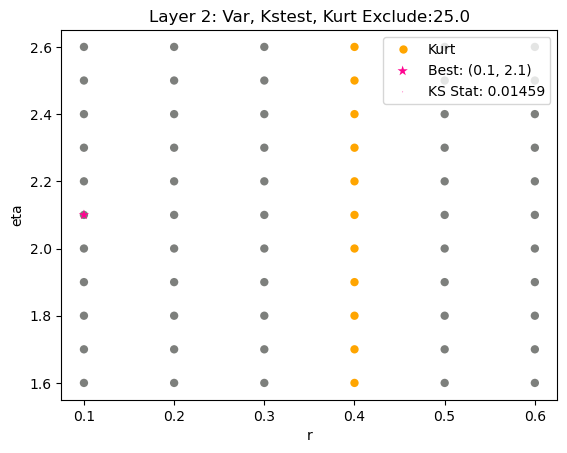

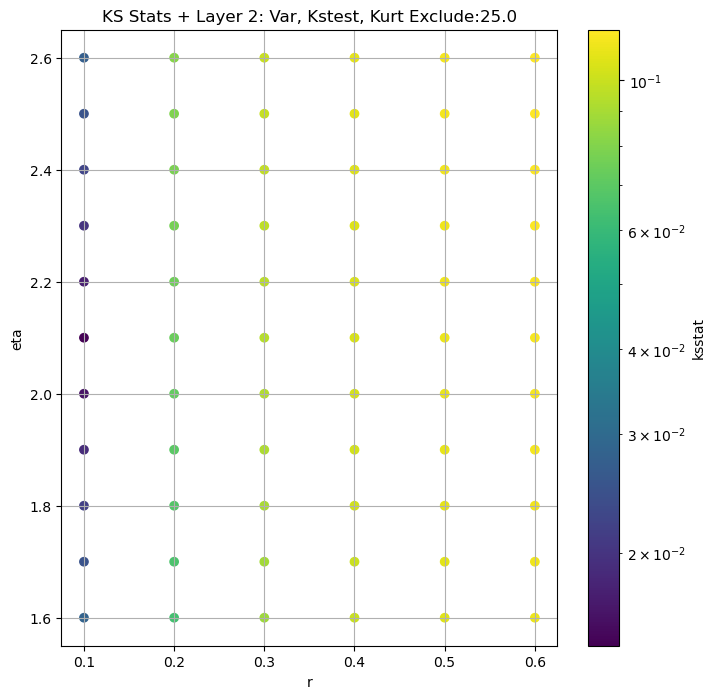

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.03196738239563768 42567.688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.019236773683409758 17821.248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.016328458982704963 14721.17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01544006182271565 13259.211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.014276676640139319 12236.628


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.013908302776018622 10732.102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.01322491467900433 9663.301


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01394948401909235 8833.764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.014649398665353974 8160.329


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.01671056122797776 7600.583


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.019228655749981227 6365.4526
Number of samples: 36000, Without approximation : 36000


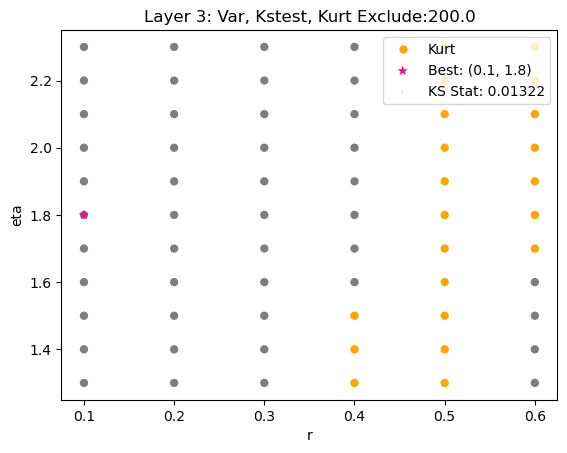

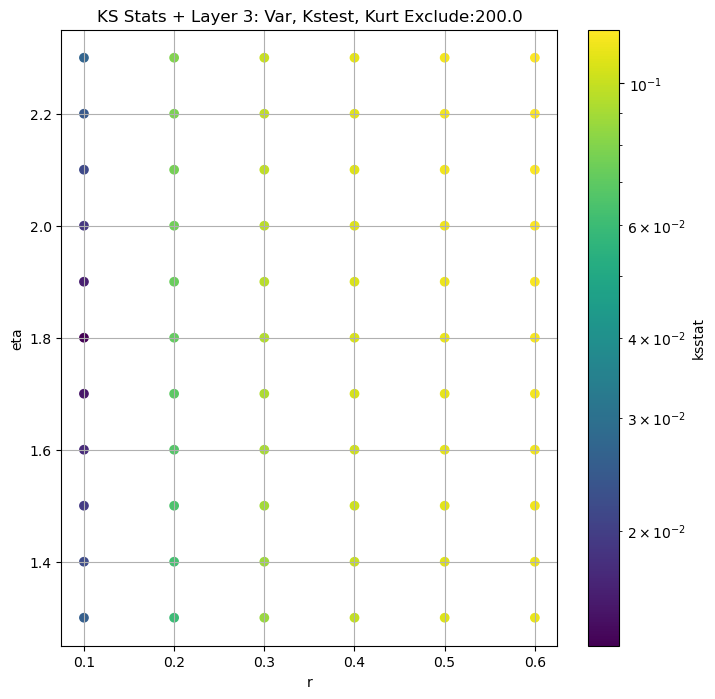

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.033607983097976635 10773.024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.023849366294957042 5597.1255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.019676766158729153 4464.322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.01907523017028978 3925.4954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.01748291877492042 3575.0303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.01367800233845795 3107.378


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.013409145525706878 2816.8918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.011617828606589747 2605.5068


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.010696293834771692 2443.7412


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.010106309392083485 2310.5107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009241875123453536 2000.6056
Number of samples: 100000, Without approximation : 144000


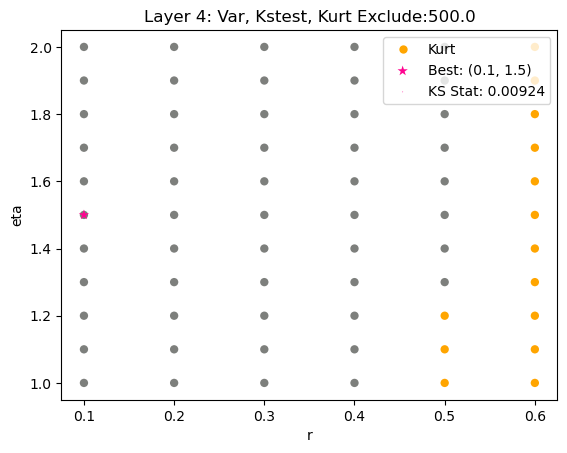

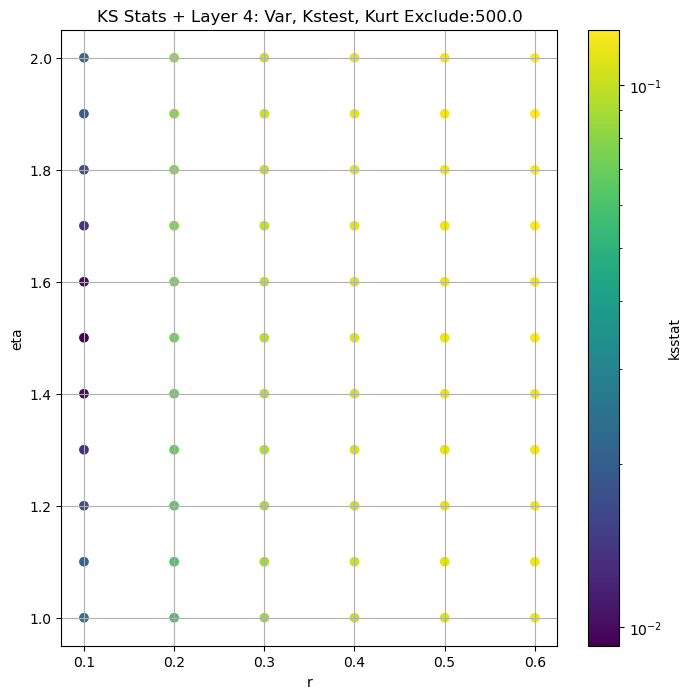

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.031780809344649 1800.4326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.022099778361144656 967.23114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.018538126033213573 795.41876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.015022138313238287 702.7499


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.014129919307775074 642.7204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.010990145010655206 566.3141


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.010367019555420381 515.4769


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007895233401820079 477.08423


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.007348840656757671 446.19592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00698149142095561 420.566


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008227178308270244 363.6727
Number of samples: 100000, Without approximation : 576000


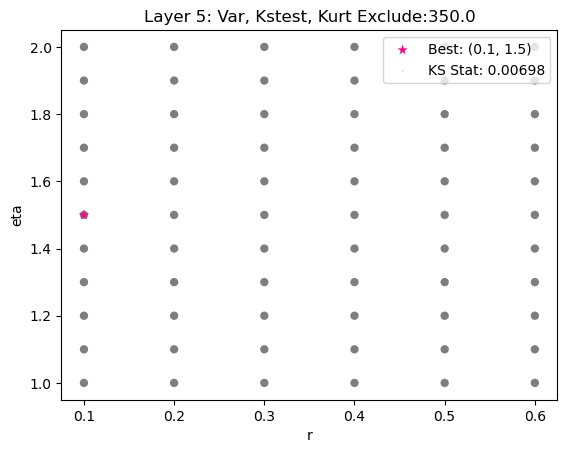

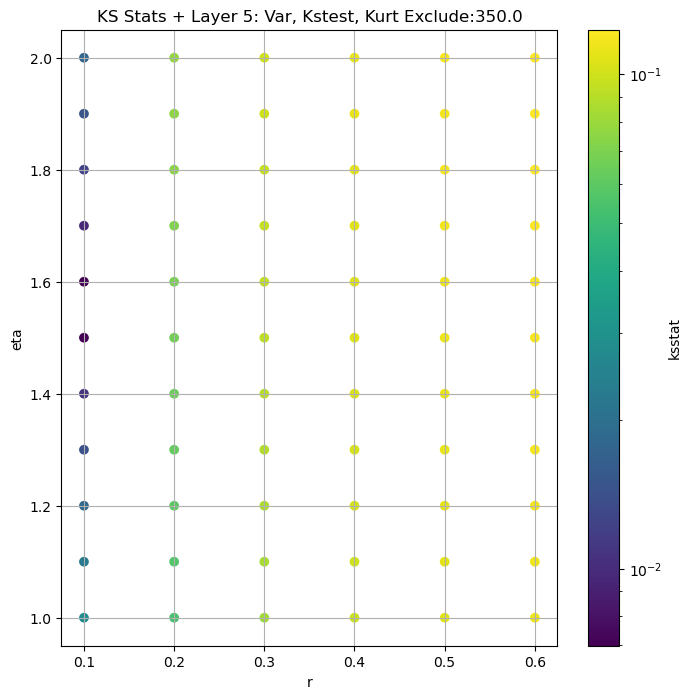

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.0334893342081444 390.86823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.020535133569096253 192.20058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.015385376472367596 158.69347


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.01302840087543966 141.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.010964899107795426 129.3658


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008398581380743037 114.13001


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.006052563446973802 104.11445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.004819134533919023 96.79748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.004748865099778232 91.05487


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.005331047690492419 86.33637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.007172877400470012 75.97701
Number of samples: 100000, Without approximation : 2304000


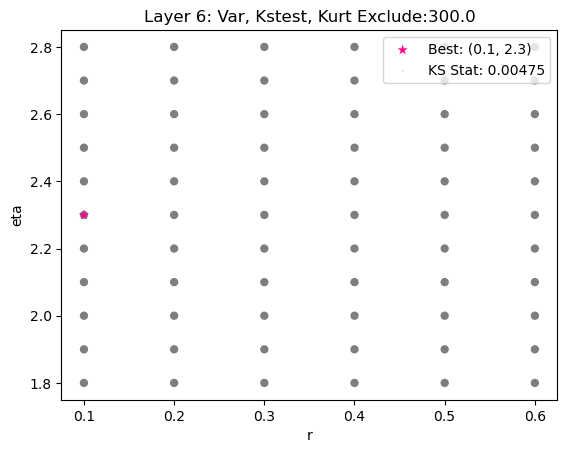

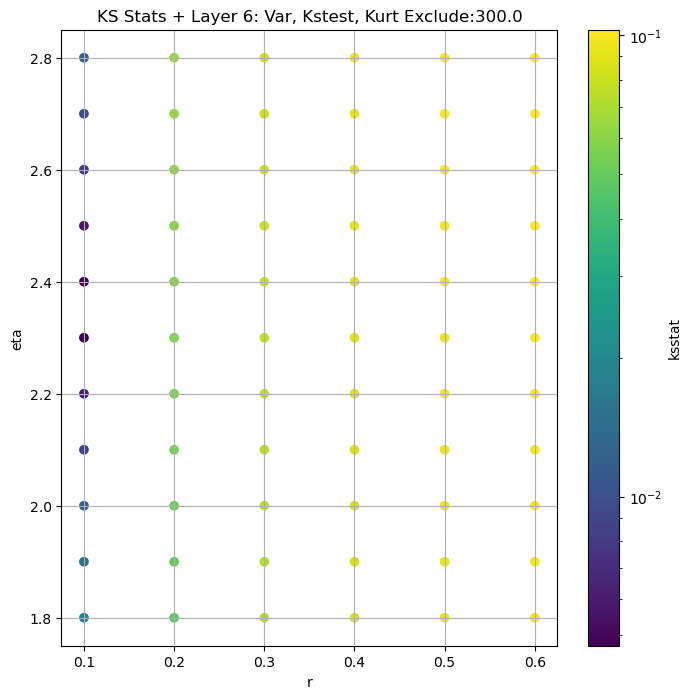

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.033318873607149135 98.47588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.015279932441623734 42.508327


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.011018410734286999 35.698204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.008614769502391706 32.237007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.006424685807146835 29.994545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.004119139611958755 27.105145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.004022848273194823 25.20578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.003928888554718624 23.804564


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004396546243282007 22.697325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004980517112498695 21.784714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006792088688901132 19.74446
Number of samples: 100000, Without approximation : 9216000


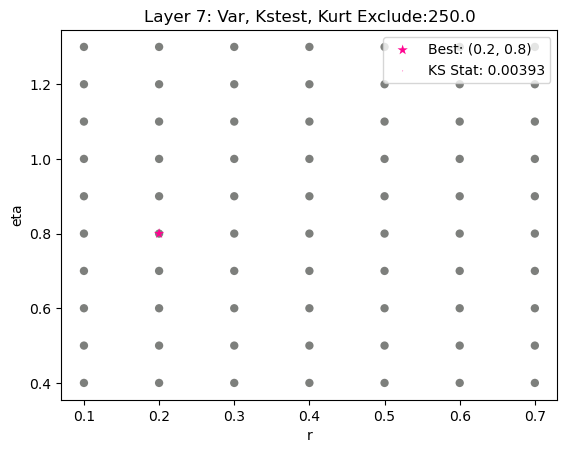

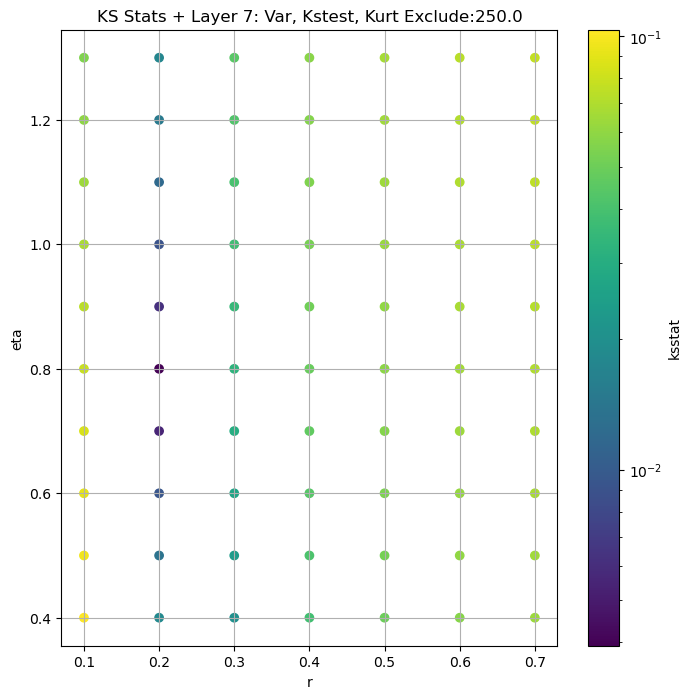

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.026066044000687405 33.197308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010034470088254421 16.510765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005939277620478467 13.967685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0035105297022210435 12.693188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0026314211453489222 11.897679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0027916175113037456 10.899511


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.0028939027655286997 10.254161


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0035933771658355207 9.773526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.004331178656200141 9.388217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005012844443235354 9.064808


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.006910321956494325 8.316537
Number of samples: 100000, Without approximation : 36864000


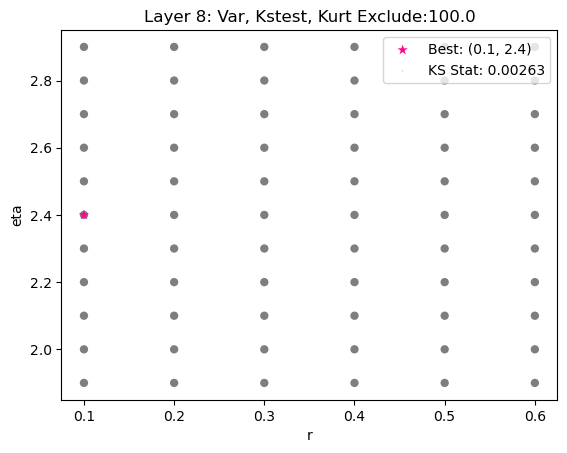

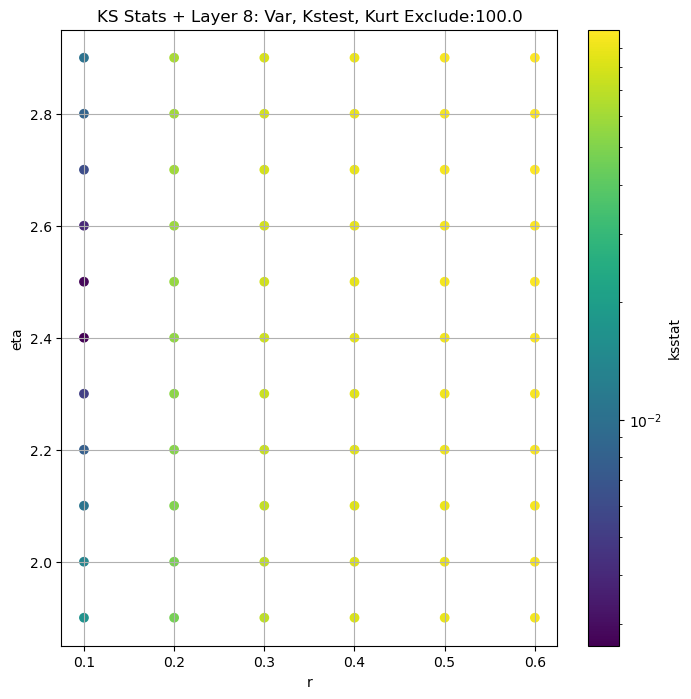

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.029917054640902885 11.251238


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.011614983966701353 4.575631


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.006957489855462684 3.8487856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.005344225927480517 3.4969726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.004046147842653169 3.2811267


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.0025015457230307915 3.0077963


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0031868892563561412 2.8254442


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.003996979687623775 2.6868286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.0048620520431542635 2.5741308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.005358275384973438 2.478742


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007130915187423481 2.2565932
Number of samples: 100000, Without approximation : 147456000


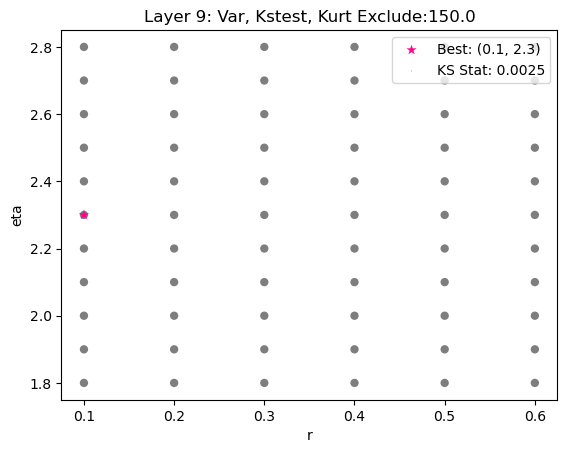

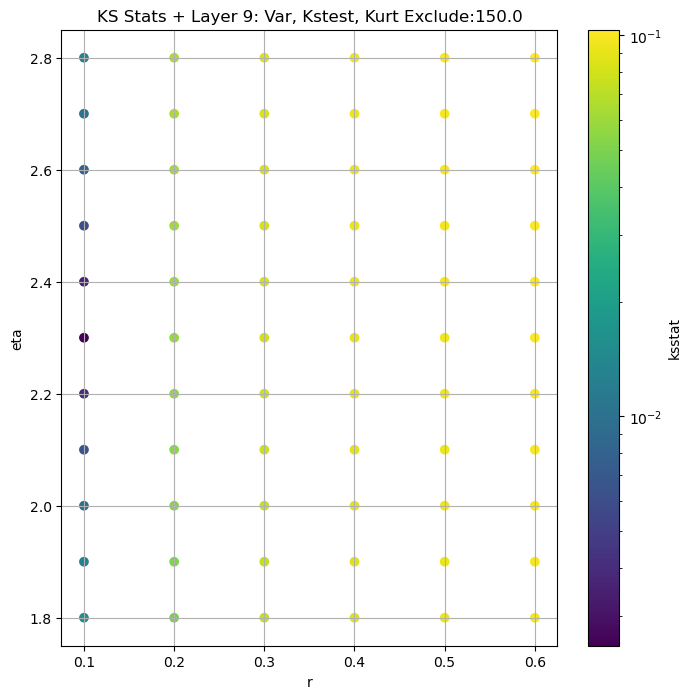

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.034078362553768046 1.8759975


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.014725605972431138 0.6423505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.011427019775855057 0.5439473


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.009662472404437933 0.49495015


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.00743040663272132 0.4638048


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.00649389074568385 0.4232818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.0049425871812087685 0.39593908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.005044307457826913 0.37513676


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.00597683288112516 0.35824314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.0062628360137824135 0.343964


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.008163892072244883 0.31076533
Number of samples: 100000, Without approximation : 589824000


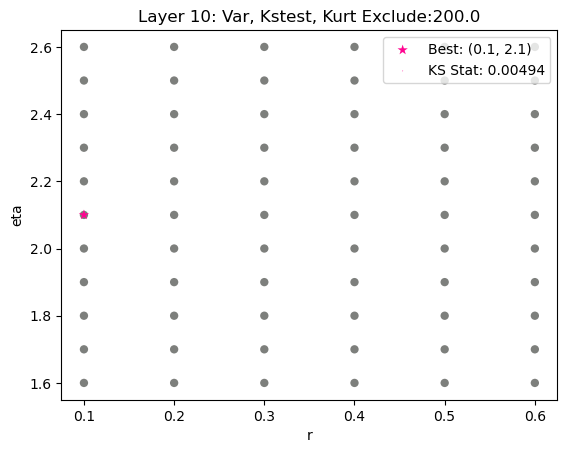

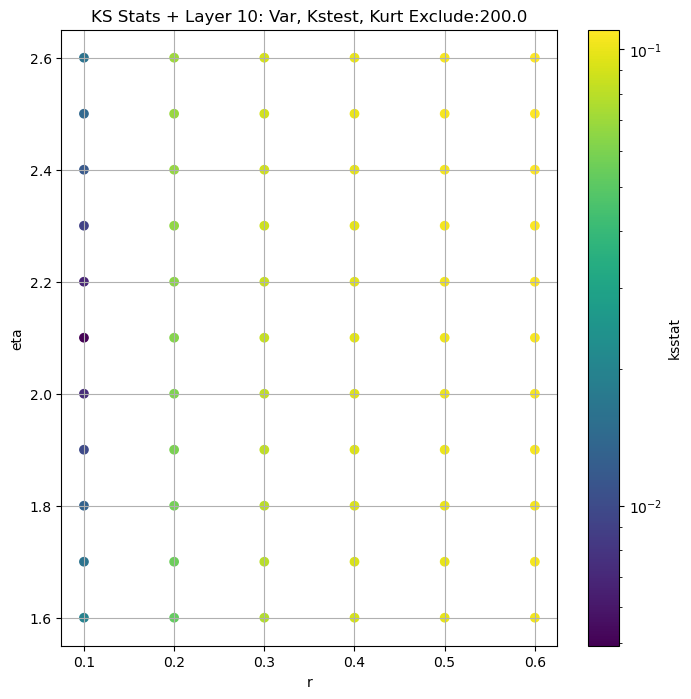

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188568.480000  99639.690000  330252.970000   536.04070  113.300850   
3       42567.688000  23775.207000   71603.100000   488.98392  135.977050   
4       10773.024000   5322.706500   20877.057000   785.26250  131.367690   
5        1800.432600    923.804400    3624.768300   858.10016  109.904150   
6         390.868230    183.293870     971.229200  1521.27820  104.049050   
7          98.475880     41.018330     351.574460  3306.41400   84.385180   
8          33.197308     15.931733     100.442570  2270.34400   78.311700   
9          11.251238      4.427770      43.867798  5139.56200   82.370804   
10          1.875997      0.616800      10.130054  9748.24700   78.492170   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        760.9477           9000             0.014587        0.1          2.1   
3        891.2222          36000             0.013225        0.1          1.8   
4       1768.9650         144000             0.009242        0.1          1.5   
5       2074.9510         576000             0.006981        0.1          1.5   
6       3444.5947        2304000             0.004749        0.1          2.3   
7       5671.7730        9216000             0.003929        0.2          0.8   
8       4640.2104       36864000             0.002631        0.1          2.4   
9       6105.7310      147456000             0.002502        0.1          2.3   
10      7481.5290      589824000             0.004943        0.1          2.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.600273e-12                    25.0        53255.293000   
3       1.809752e-12                   200.0         9663.301000   
4       8.671919e-13                   500.0         2000.605600   
5       1.823005e-13                   350.0          420.566000   
6       4.845878e-15                   300.0           91.054870   
7       5.457816e-05                   250.0           23.804564   
8       5.012726e-16                   100.0           11.897679   
9       1.600729e-16                   150.0            3.007796   
10      3.420182e-17                   200.0            0.395939   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.02408927168947983, var: 33320.63671875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.02145073031836031, var: 36419.86328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.018547360453705863, var: 40213.46484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.01560996297304651, var: 45081.33203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.01394518341100448, var: 53255.29296875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.025759994721602175, var: 188568.484375
Number of samples: 9000, Without approximation : 9000


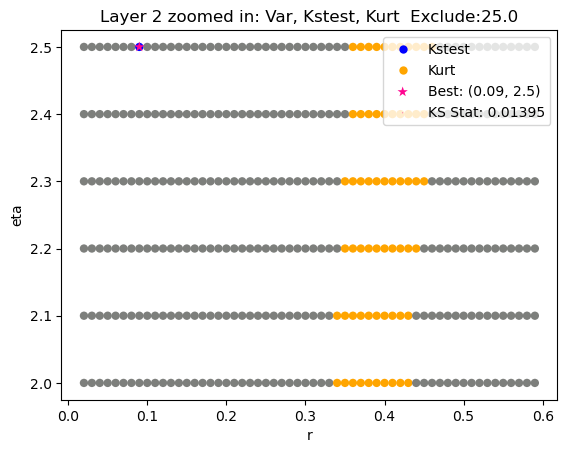

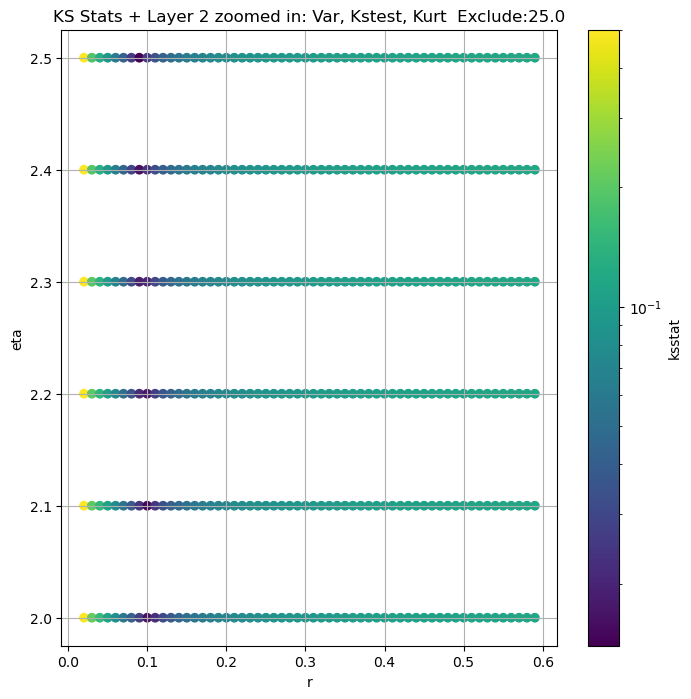

Layer 3


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 100 = 300, ksstat: 0.01597592856302299, var: 8160.3291015625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 75 = 275, ksstat: 0.014995055049934591, var: 8481.3759765625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 50 = 250, ksstat: 0.013970083524877608, var: 8833.763671875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 25 = 225, ksstat: 0.013349074765489854, var: 9224.3427734375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + 0 = 200, ksstat: 0.01322491467900433, var: 9663.30078125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -25 = 175, ksstat: 0.0135378743229842, var: 10158.2578125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -50 = 150, ksstat: 0.013908302776018622, var: 10732.1015625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -75 = 125, ksstat: 0.013677009788009453, var: 11404.9033203125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 3, 200.0 + -100 = 100, ksstat: 0.014276676640139319, var: 12236.6279296875
Number of samples: 36000, Without approximation : 36000


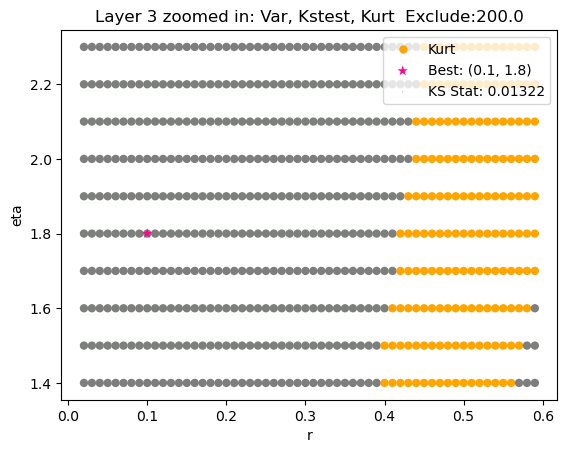

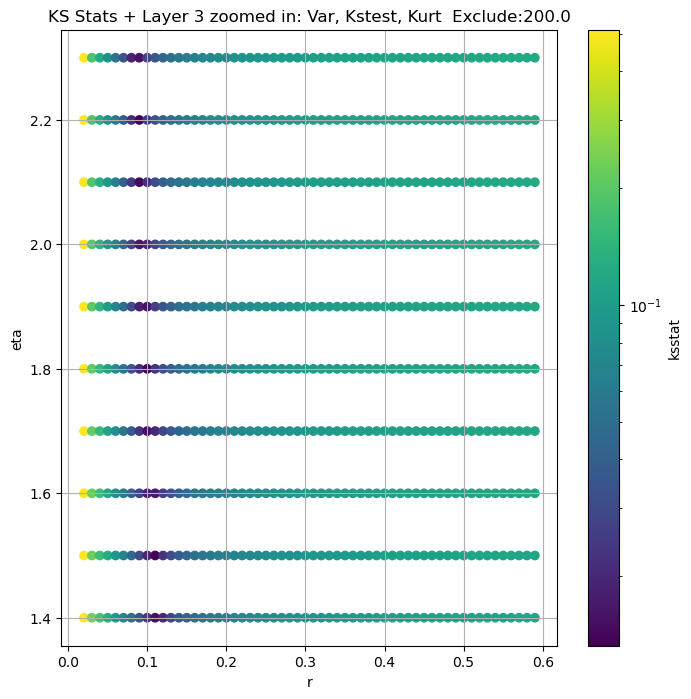

Layer 4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.01038099813653881, var: 1844.8775634765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.010088862294393097, var: 1880.7161865234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.009731904905993405, var: 1918.5224609375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.009470439365022454, var: 1958.42138671875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.009163111698924808, var: 2000.6055908203125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.008759764242911472, var: 2045.0811767578125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.008517434282791614, var: 2092.228759765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.008078027979977143, var: 2142.141845703125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.008024630032559738, var: 2194.90283203125
Number of samples: 100000, Without approximation : 144000


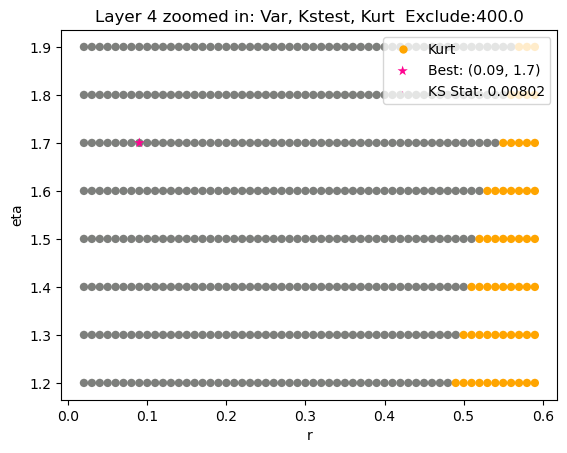

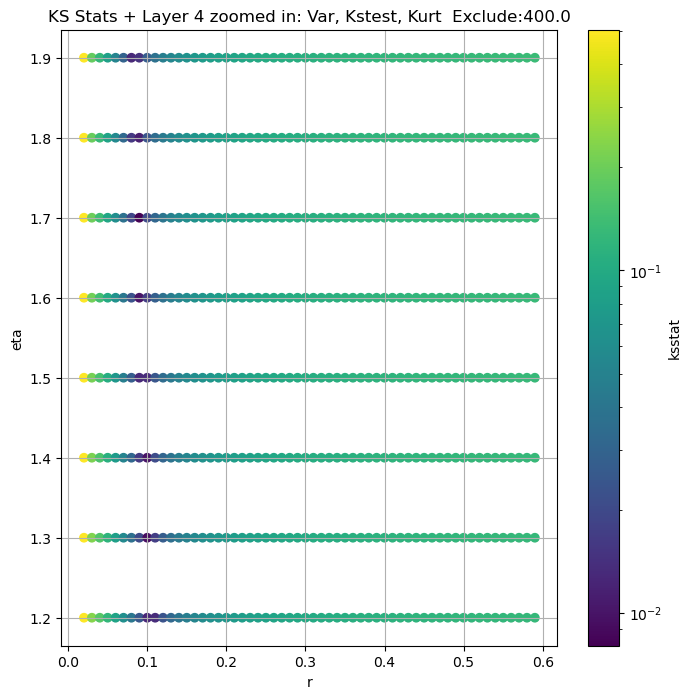

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.007835291576750003, var: 380.14288330078125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007513932675225821, var: 389.2176208496094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.007171721513392293, var: 398.9103698730469


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.006857263919116563, var: 409.2983093261719


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.00658589802137155, var: 420.5660095214844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.006438990286448815, var: 432.80133056640625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.006842069458205924, var: 446.1959228515625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.006888062141492068, var: 460.9139099121094


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.007895233401820079, var: 477.084228515625
Number of samples: 100000, Without approximation : 576000


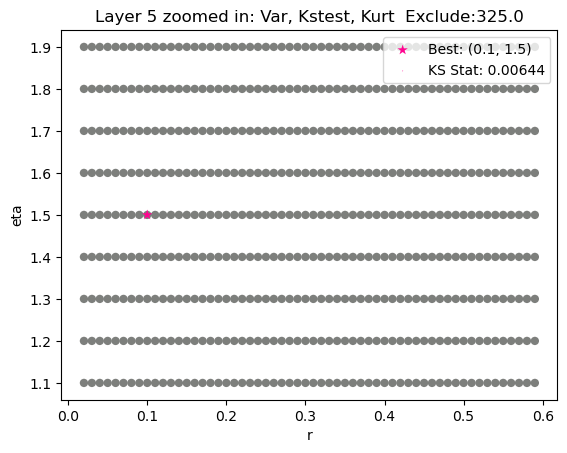

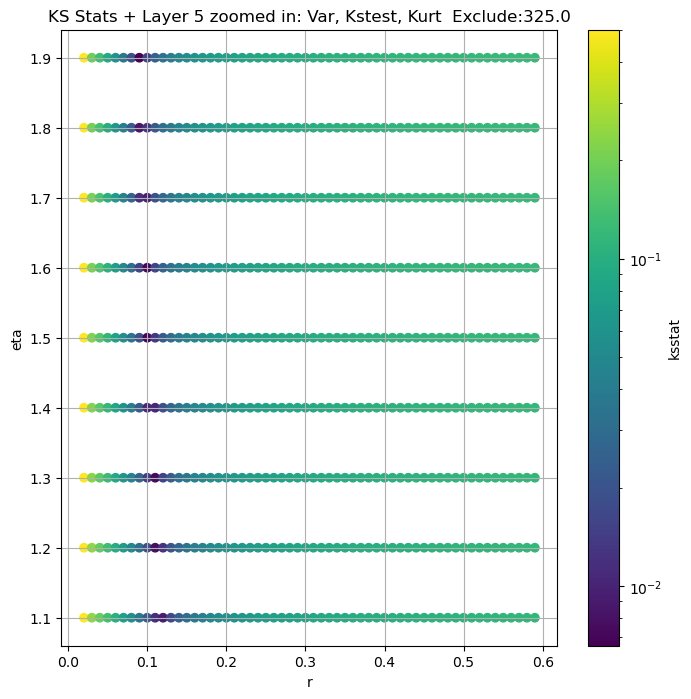

Layer 6


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 100 = 400, ksstat: 0.006064395443734161, var: 82.37004089355469


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 75 = 375, ksstat: 0.00573158708538013, var: 84.27571868896484


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 50 = 350, ksstat: 0.0053827500971399544, var: 86.33637237548828


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 25 = 325, ksstat: 0.005072589079873735, var: 88.5859603881836


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + 0 = 300, ksstat: 0.004717312634951232, var: 91.05487060546875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -25 = 275, ksstat: 0.00439003634158075, var: 93.77017974853516


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -50 = 250, ksstat: 0.004545992397192444, var: 96.79747772216797


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -75 = 225, ksstat: 0.005467267549452592, var: 100.2083969116211


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 300.0 + -100 = 200, ksstat: 0.0059073723853726445, var: 104.11444854736328
Number of samples: 100000, Without approximation : 2304000


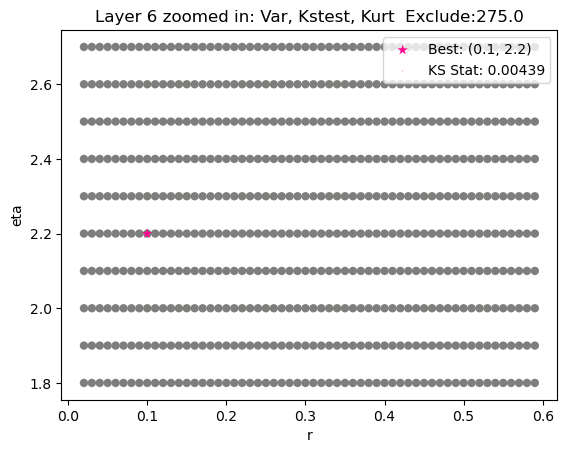

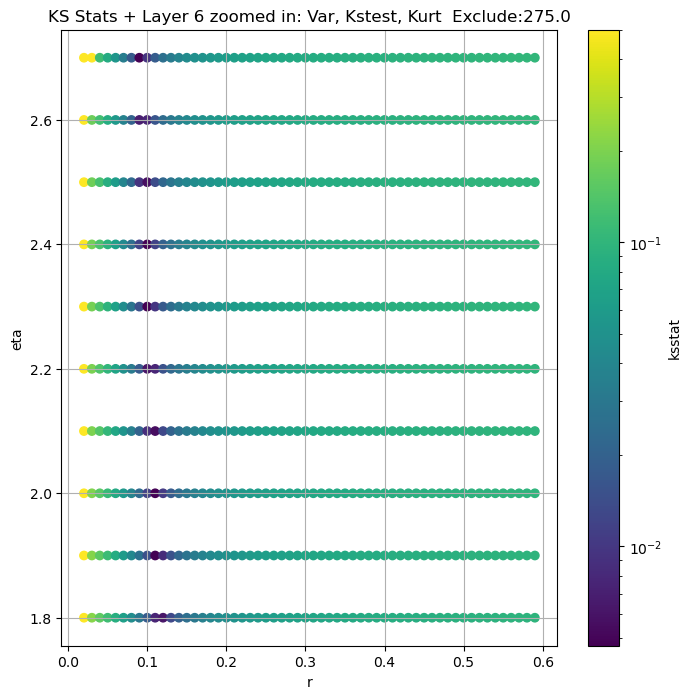

Layer 7


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 100 = 350, ksstat: 0.004956527583432291, var: 21.784713745117188


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 75 = 325, ksstat: 0.004659163804073496, var: 22.221027374267578


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 50 = 300, ksstat: 0.004332029421841077, var: 22.697324752807617


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 25 = 275, ksstat: 0.004002689581789065, var: 23.22153091430664


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + 0 = 250, ksstat: 0.0038546323022855544, var: 23.804563522338867


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -25 = 225, ksstat: 0.0037169860143119182, var: 24.45922088623047


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -50 = 200, ksstat: 0.0038680555171481945, var: 25.205780029296875


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -75 = 175, ksstat: 0.0049915819240306525, var: 26.07353401184082


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 7, 250.0 + -100 = 150, ksstat: 0.005072197617200569, var: 27.105144500732422
Number of samples: 100000, Without approximation : 9216000


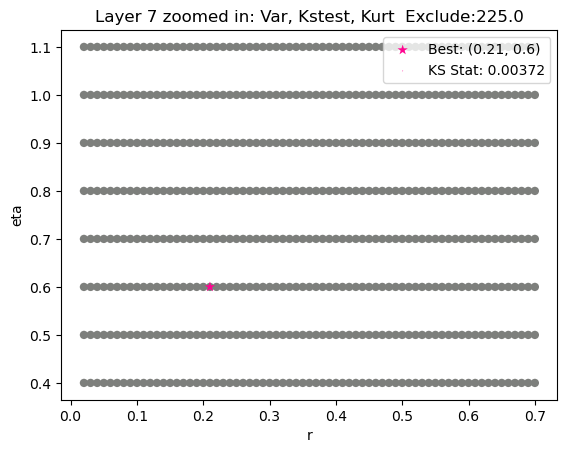

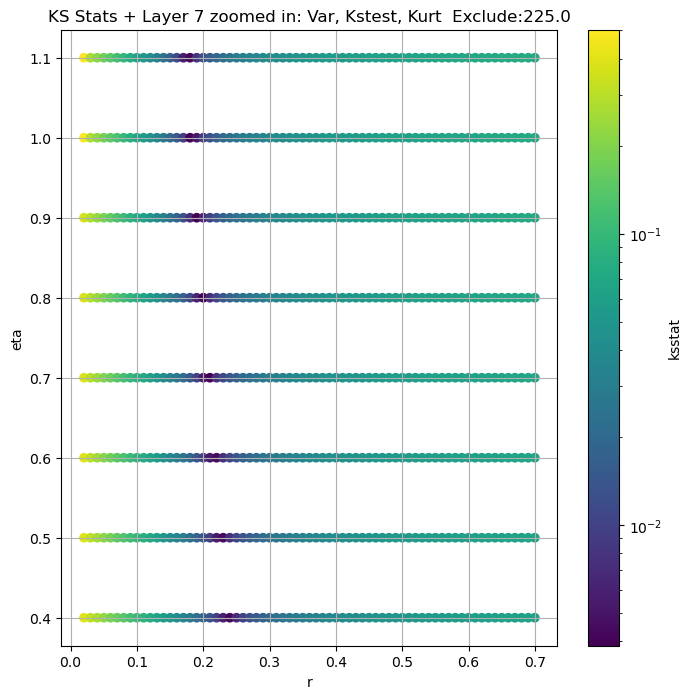

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 100 = 200, ksstat: 0.0031713974393418054, var: 10.25416088104248


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 75 = 175, ksstat: 0.0028286948424887104, var: 10.54899787902832


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 50 = 150, ksstat: 0.0027276342466548975, var: 10.899511337280273


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 25 = 125, ksstat: 0.002669530374267204, var: 11.332716941833496


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + 0 = 100, ksstat: 0.0026314211453489222, var: 11.897679328918457


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -25 = 75, ksstat: 0.003485836573880907, var: 12.693187713623047


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -50 = 50, ksstat: 0.005705641684836782, var: 13.967684745788574


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -75 = 25, ksstat: 0.009286130687771954, var: 16.510765075683594


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 100.0 + -100 = 0, ksstat: 0.021910971438677096, var: 33.19730758666992
Number of samples: 100000, Without approximation : 36864000


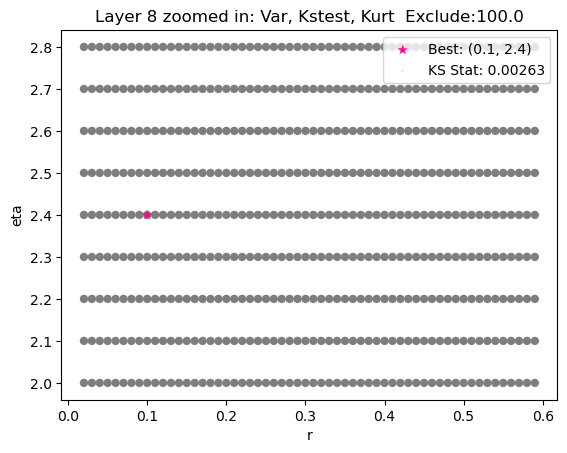

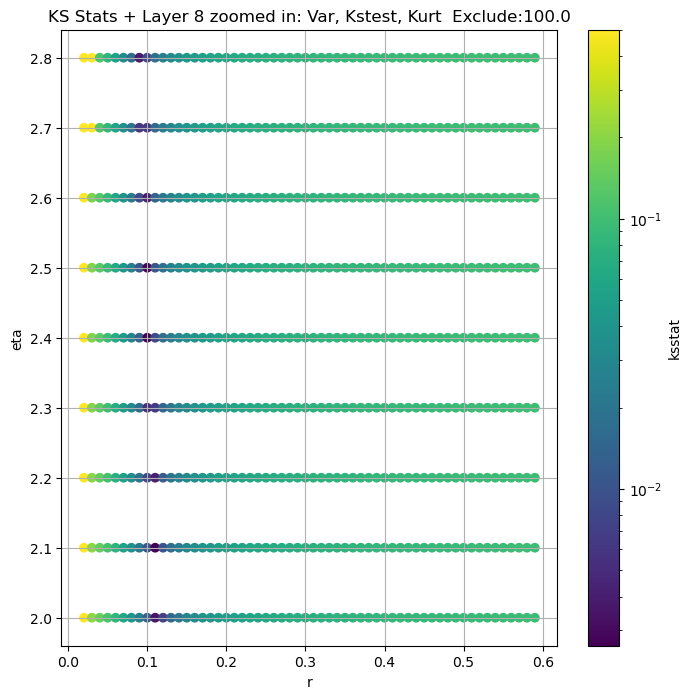

Layer 9


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 100 = 250, ksstat: 0.004354233657589024, var: 2.68682861328125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 75 = 225, ksstat: 0.003842712050358816, var: 2.752108573913574


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 50 = 200, ksstat: 0.003350508654978856, var: 2.825444221496582


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 25 = 175, ksstat: 0.002908444843535262, var: 2.9093799591064453


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + 0 = 150, ksstat: 0.00249942308496476, var: 3.007796287536621


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -25 = 125, ksstat: 0.002265014524069464, var: 3.1274306774139404


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -50 = 100, ksstat: 0.0036553736434536965, var: 3.2811267375946045


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -75 = 75, ksstat: 0.004952357568604793, var: 3.4969725608825684


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 9, 150.0 + -100 = 50, ksstat: 0.006620435779166156, var: 3.848785638809204
Number of samples: 100000, Without approximation : 147456000


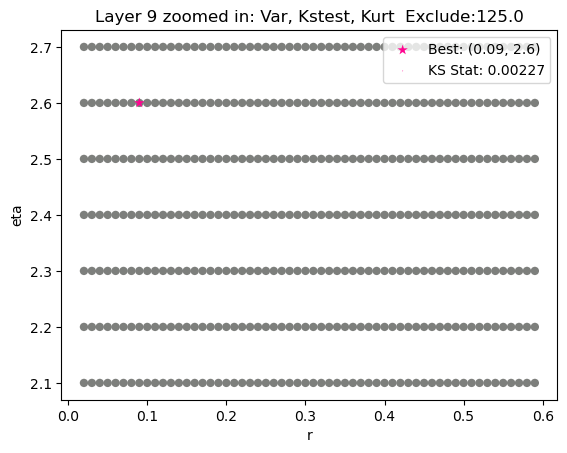

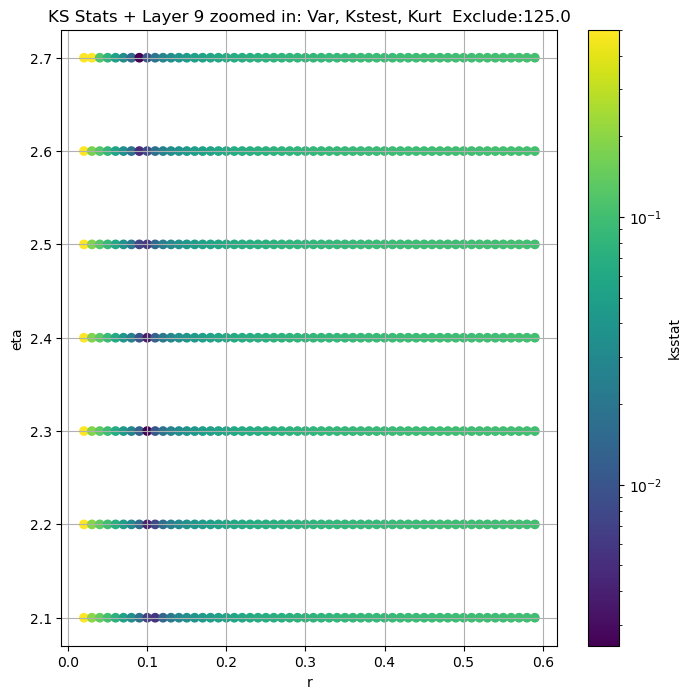

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 100 = 300, ksstat: 0.005889702005689168, var: 0.3582431375980377


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 75 = 275, ksstat: 0.005384893466282903, var: 0.366301029920578


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 50 = 250, ksstat: 0.004990703020698373, var: 0.37513676285743713


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 25 = 225, ksstat: 0.004556184514517003, var: 0.38493117690086365


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + 0 = 200, ksstat: 0.0049425871812087685, var: 0.39593908190727234


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -25 = 175, ksstat: 0.005751370973688719, var: 0.4085337817668915


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -50 = 150, ksstat: 0.0062954063535002325, var: 0.42328178882598877


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -75 = 125, ksstat: 0.006630045674632101, var: 0.44113263487815857


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 200.0 + -100 = 100, ksstat: 0.007372695488085945, var: 0.46380481123924255
Number of samples: 100000, Without approximation : 589824000


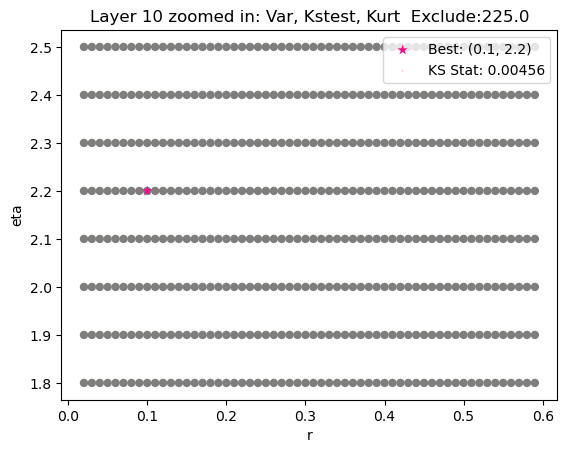

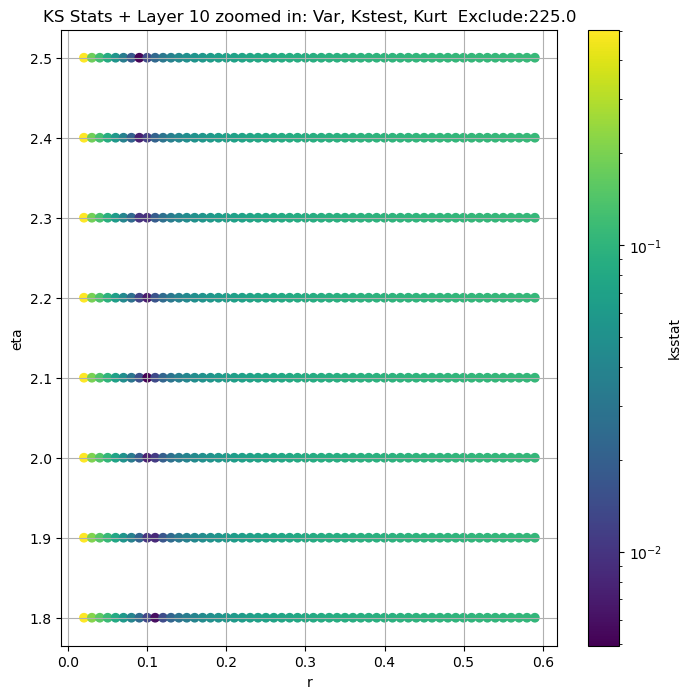

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188568.480000  99639.690000  330252.970000   536.04070  113.300850   
3       42567.688000  23775.207000   71603.100000   488.98392  135.977050   
4       10773.024000   5322.706500   20877.057000   785.26250  131.367690   
5        1800.432600    923.804400    3624.768300   858.10016  109.904150   
6         390.868230    183.293870     971.229200  1521.27820  104.049050   
7          98.475880     41.018330     351.574460  3306.41400   84.385180   
8          33.197308     15.931733     100.442570  2270.34400   78.311700   
9          11.251238      4.427770      43.867798  5139.56200   82.370804   
10          1.875997      0.616800      10.130054  9748.24700   78.492170   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        760.9477           9000             0.014587        0.1          2.1   
3        891.2222          36000             0.013225        0.1          1.8   
4       1768.9650         144000             0.009242        0.1          1.5   
5       2074.9510         576000             0.006981        0.1          1.5   
6       3444.5947        2304000             0.004749        0.1          2.3   
7       5671.7730        9216000             0.003929        0.2          0.8   
8       4640.2104       36864000             0.002631        0.1          2.4   
9       6105.7310      147456000             0.002502        0.1          2.3   
10      7481.5290      589824000             0.004943        0.1          2.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       4.600273e-12                    25.0        53255.292969   
3       1.809752e-12                   200.0         9663.301000   
4       8.671919e-13                   500.0         2194.902832   
5       1.823005e-13                   350.0          432.801331   
6       4.845878e-15                   300.0           93.770180   
7       5.457816e-05                   250.0           24.459221   
8       5.012726e-16                   100.0           11.897679   
9       1.600729e-16                   150.0            3.127431   
10      3.420182e-17                   200.0            0.384931   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.013945    0.09       2.5   
3                     0.007153          0.013225    0.10       1.8   
4                     0.003578          0.008025    0.09       1.7   
5                     0.001789          0.006439    0.10       1.5   
6                     0.000895          0.004390    0.10       2.2   
7                     0.000447          0.003717    0.21       0.6   
8                     0.000224          0.002631    0.10       2.4   
9                     0.000112          0.002265    0.09       2.6   
10                    0.000056          0.004556    0.10       2.2   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      8.081689e-15                 25.0       9000.0  
3      1.809752e-12                200.0      10125.0  
4      3.038051e-15                400.0      28830.0  
5      1.876041e-13                325.0      45562.0  
6      6.339138e-15                275.0      91125.0  
7      1.920793e-04                225.0     136687.0  
8      5.012726e-16                100.0     273375.0  
9      3.704835e-19                125.0     364500.0  
10     2.602247e-17                225.0      91125.0

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

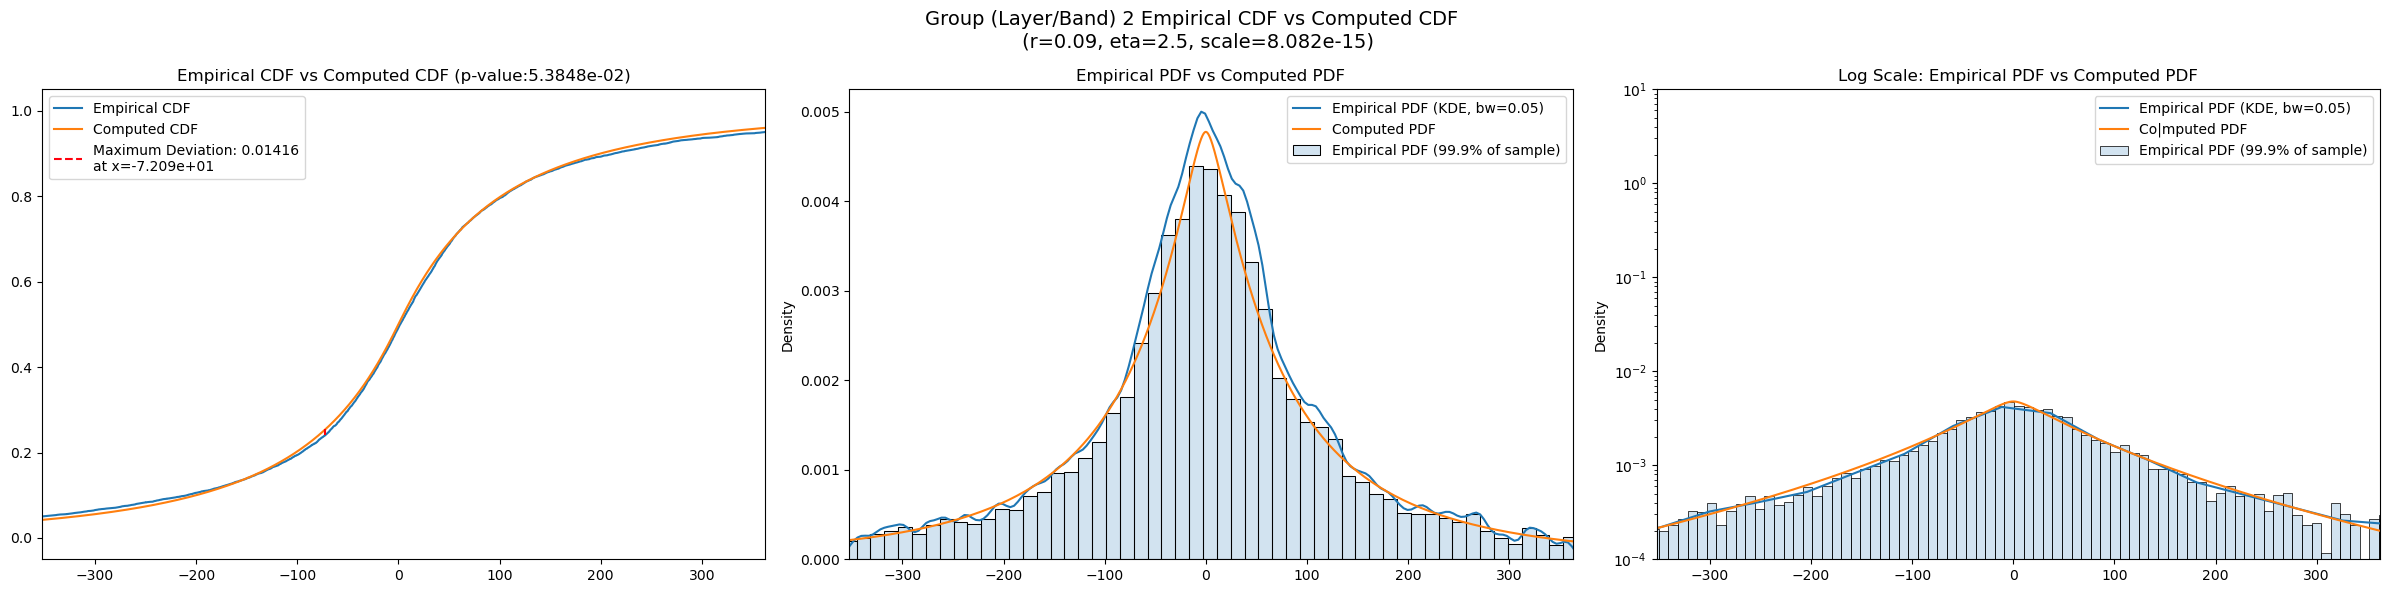

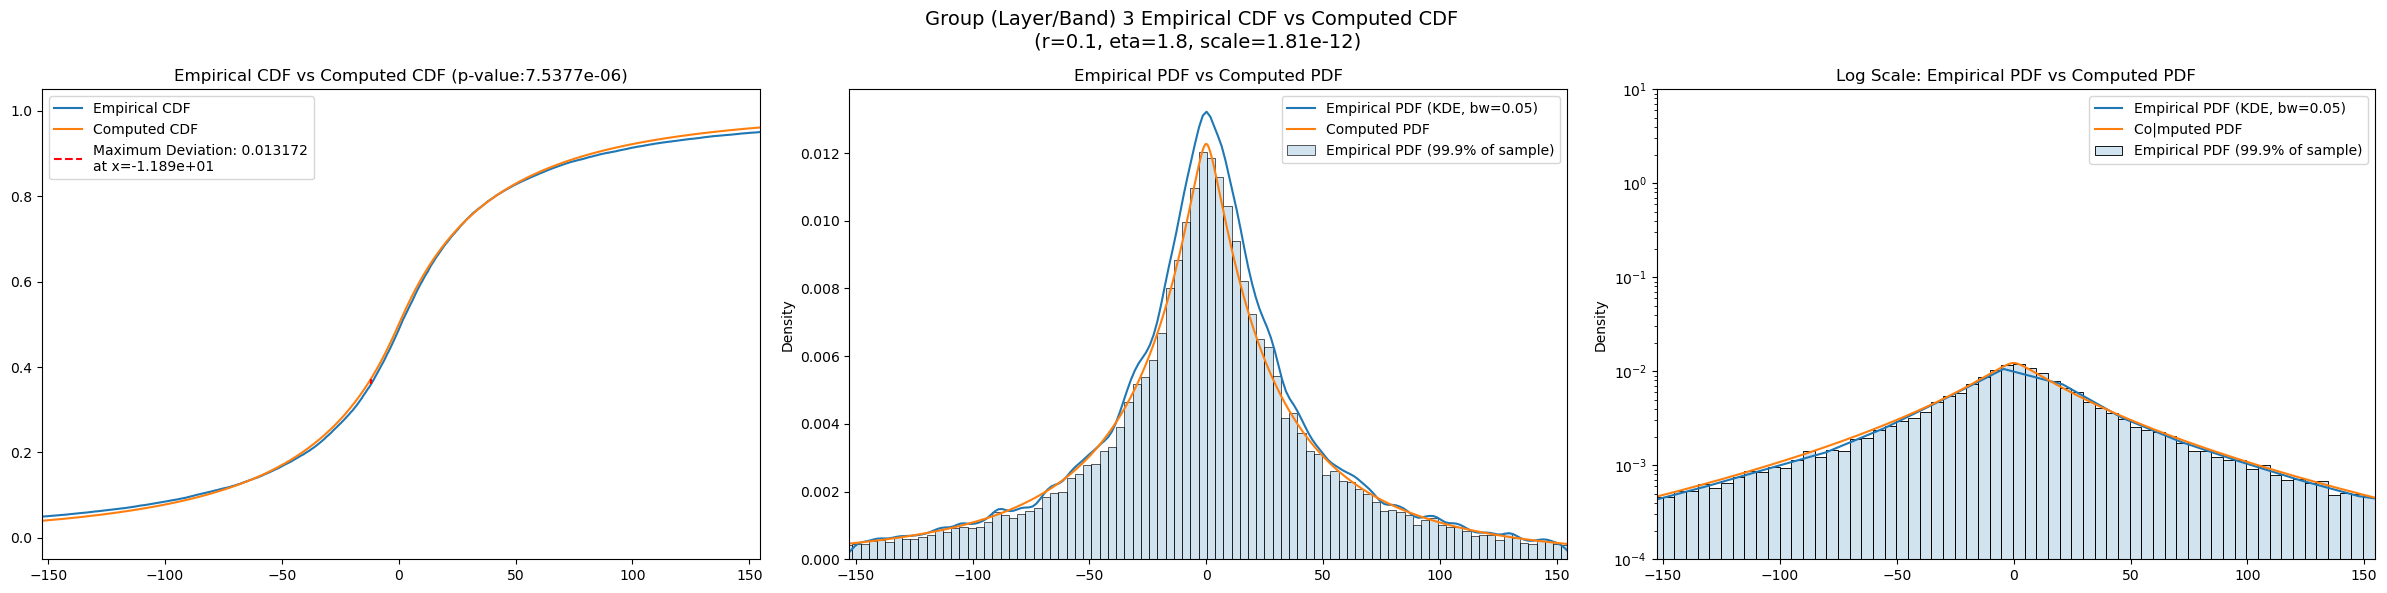

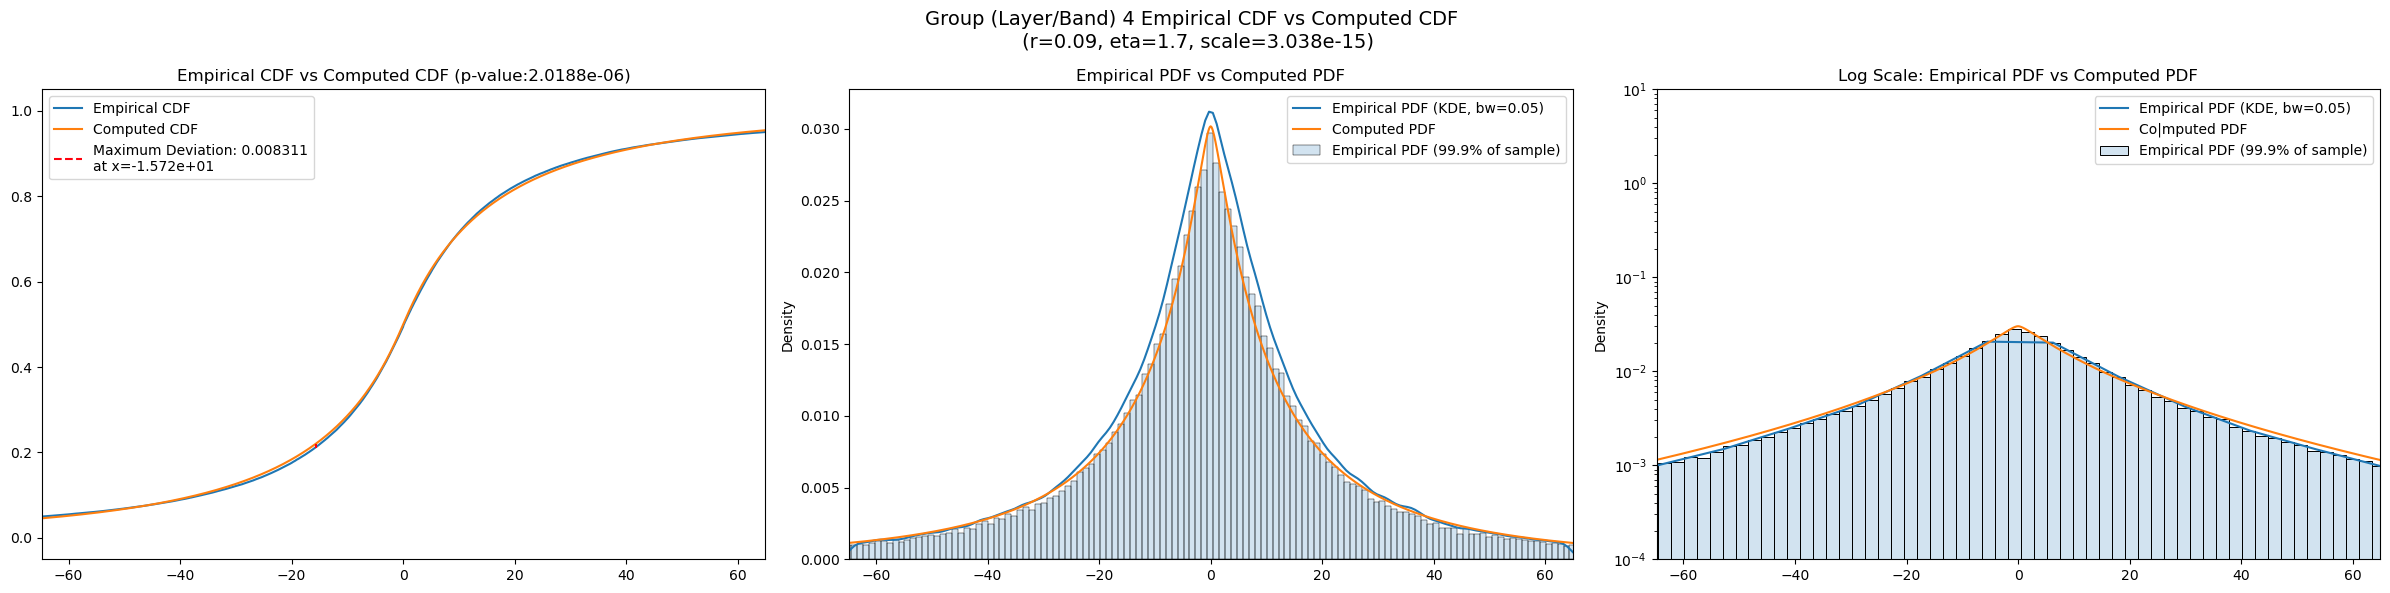

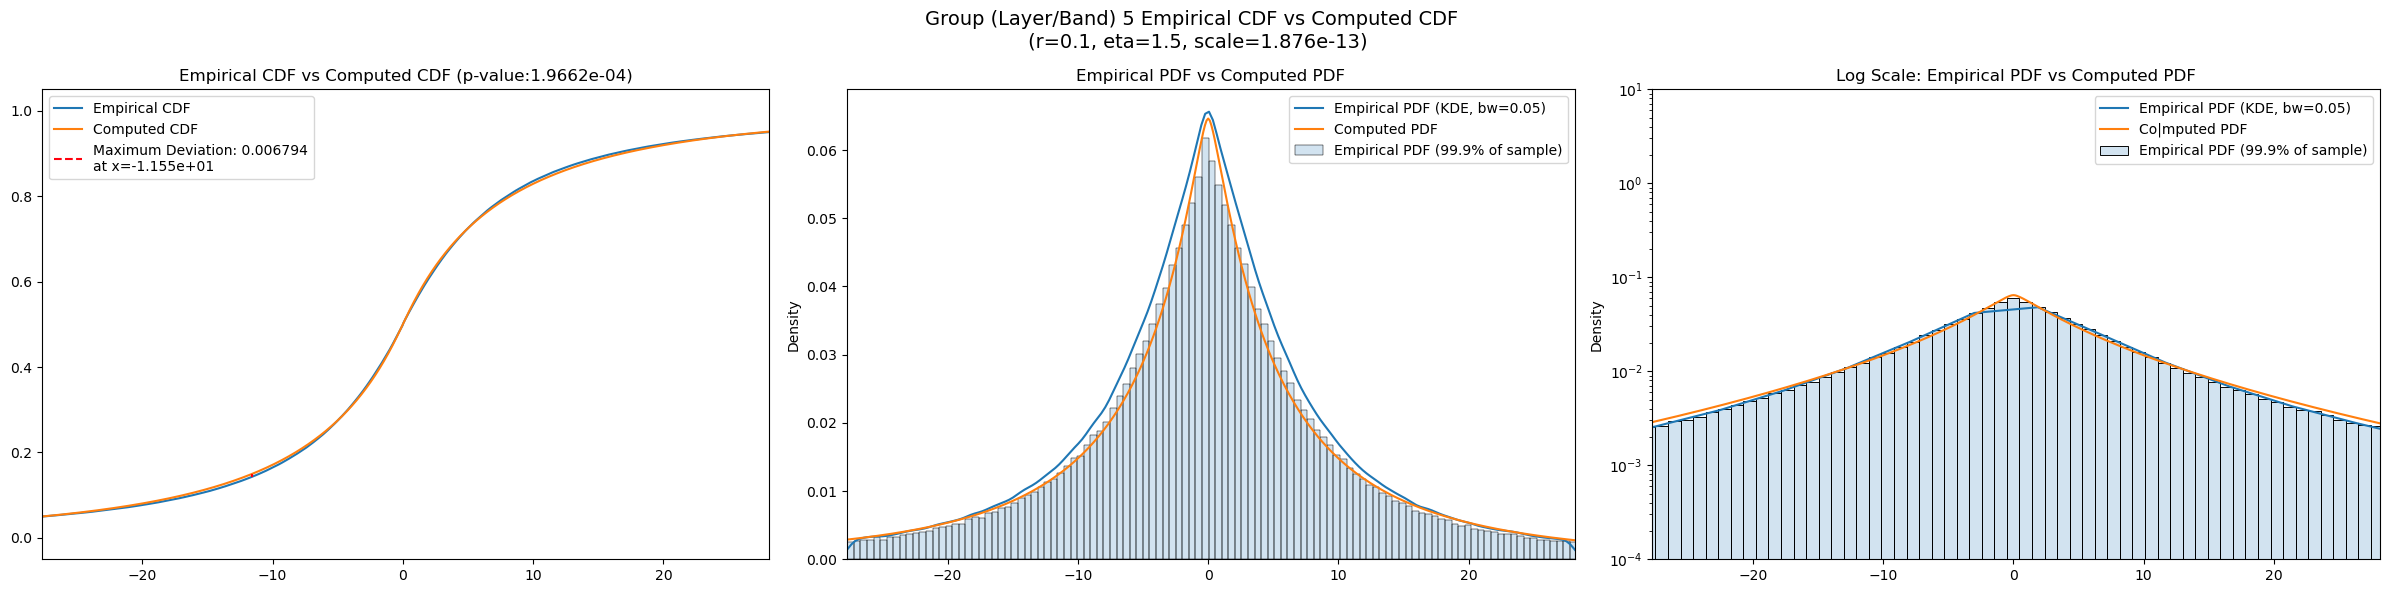

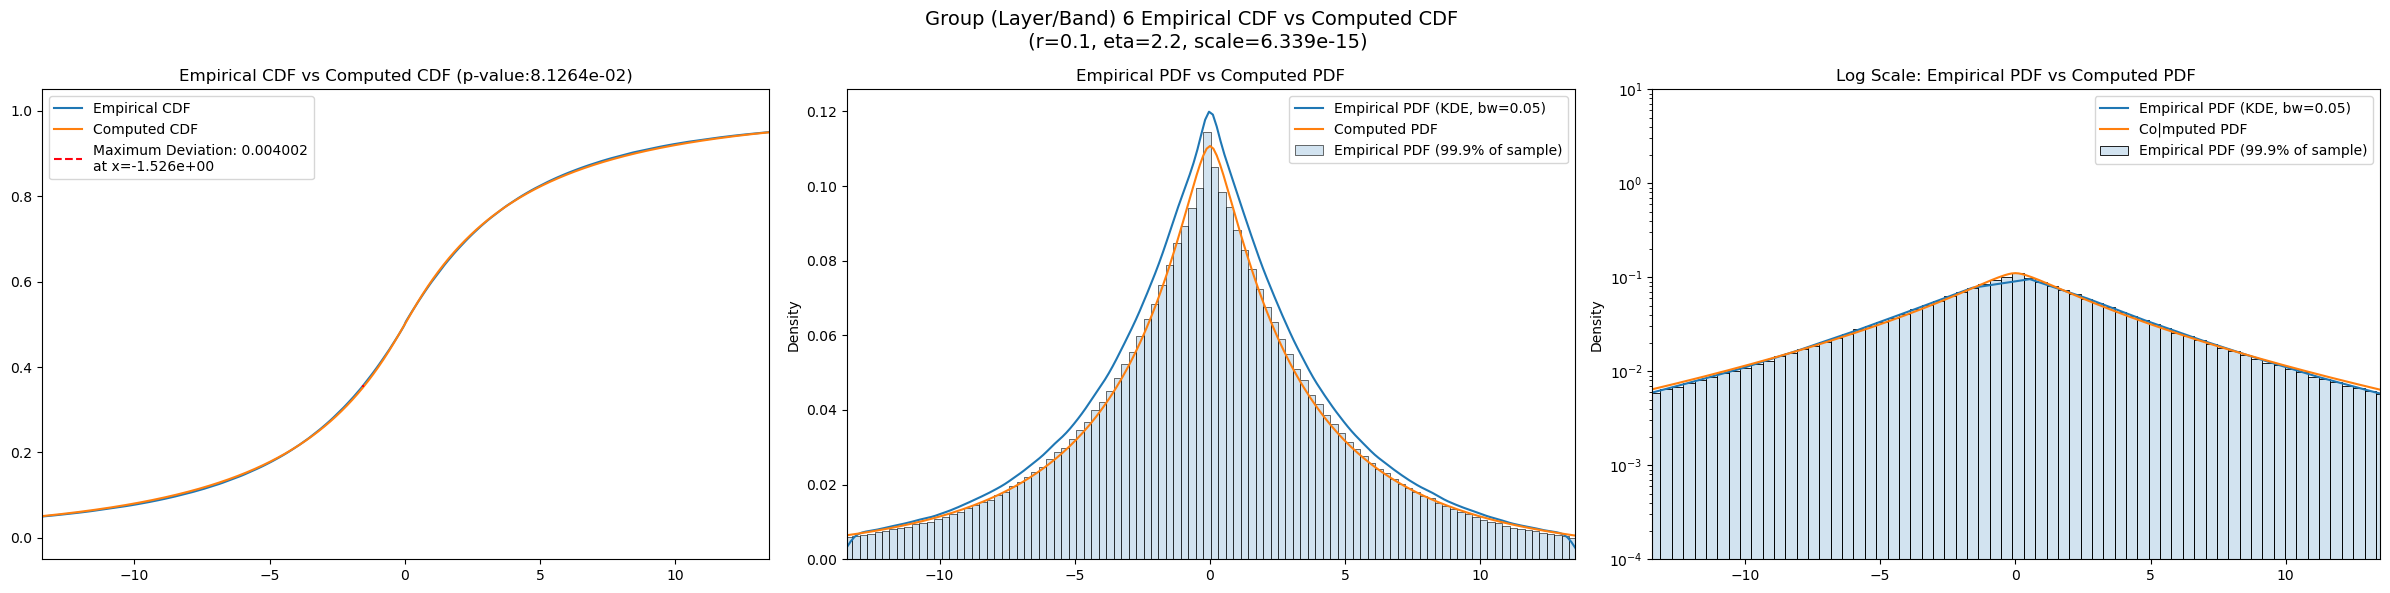

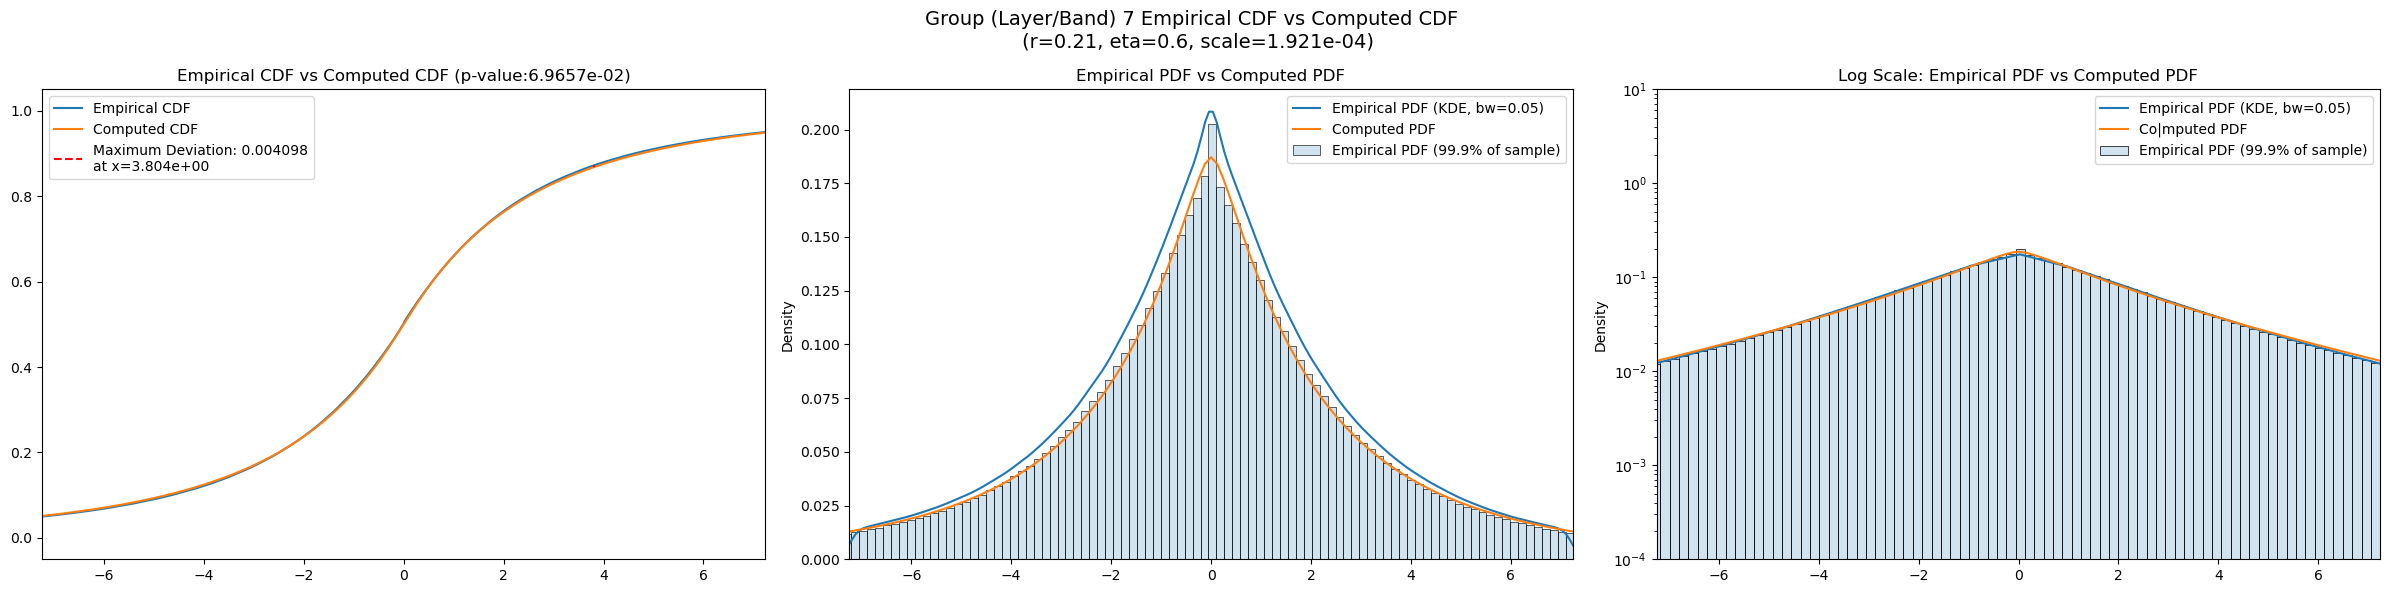

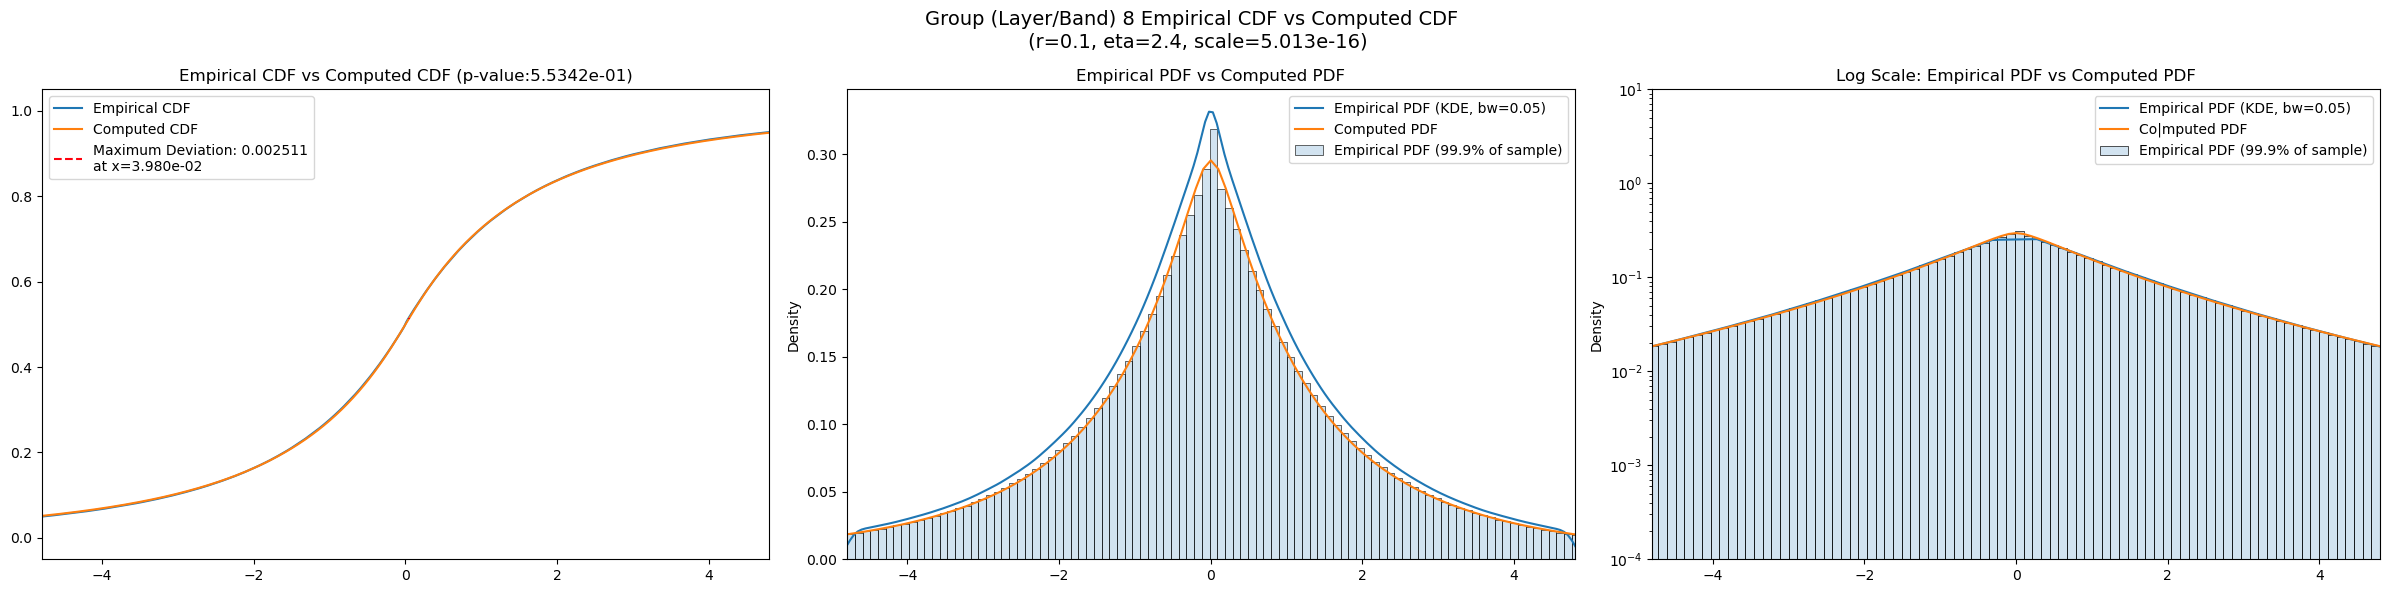

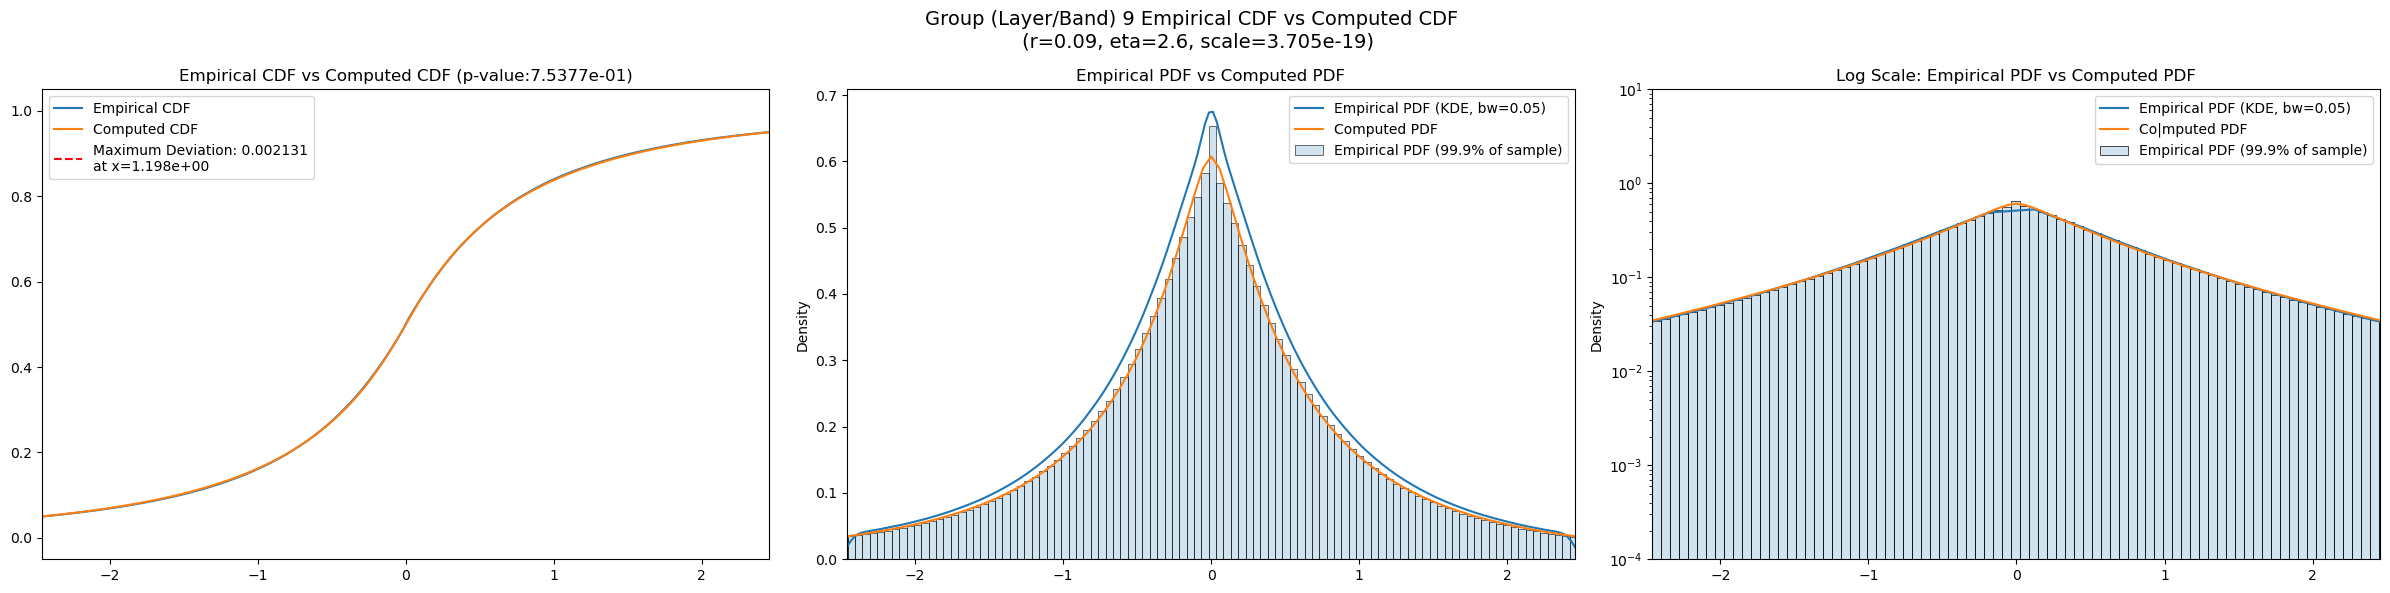

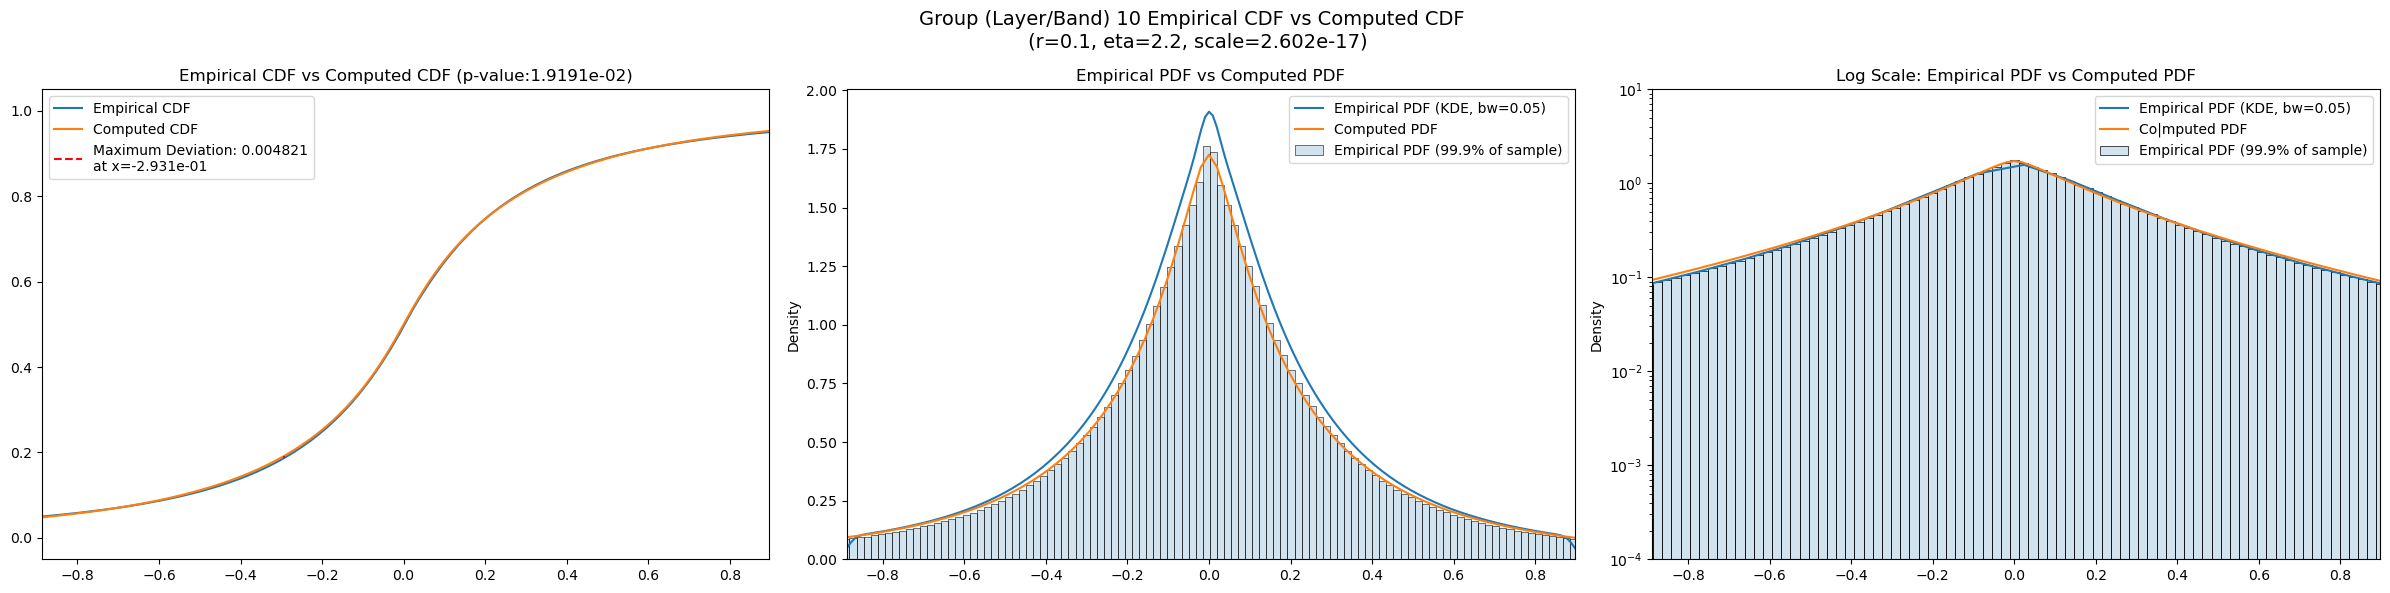

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper    obs_kurt  kurt_lower  \
layer                                                                       
2      188568.480000  99639.690000  330252.970000   536.04070  113.300850   
3       42567.688000  23775.207000   71603.100000   488.98392  135.977050   
4       10773.024000   5322.706500   20877.057000   785.26250  131.367690   
5        1800.432600    923.804400    3624.768300   858.10016  109.904150   
6         390.868230    183.293870     971.229200  1521.27820  104.049050   
7          98.475880     41.018330     351.574460  3306.41400   84.385180   
8          33.197308     15.931733     100.442570  2270.34400   78.311700   
9          11.251238      4.427770      43.867798  5139.56200   82.370804   
10          1.875997      0.616800      10.130054  9748.24700   78.492170   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        760.9477           9000             0.014587        0.1          2.1   
3        891.2222          36000             0.013225        0.1          1.8   
4       1768.9650         144000             0.009242        0.1          1.5   
5       2074.9510         576000             0.006981        0.1          1.5   
6       3444.5947        2304000             0.004749        0.1          2.3   
7       5671.7730        9216000             0.003929        0.2          0.8   
8       4640.2104       36864000             0.002631        0.1          2.4   
9       6105.7310      147456000             0.002502        0.1          2.3   
10      7481.5290      589824000             0.004943        0.1          2.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      131.895000              0.055414          1.840050e-24   
3      ...       53.592300              0.057767         7.253370e-105   
4      ...       23.147500              0.054261          0.000000e+00   
5      ...       10.882000              0.048652          0.000000e+00   
6      ...        5.731010              0.042151          0.000000e+00   
7      ...        3.212490              0.039121          0.000000e+00   
8      ...        2.081890              0.041266          0.000000e+00   
9      ...        1.034680              0.043523          0.000000e+00   
10     ...        0.362862              0.046307          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2         116.313000             0.029479         3.147920e-07  93.599700   
3          47.515600             0.031702         7.216900e-32  37.258900   
4          20.675900             0.028982        1.629090e-105  16.104500   
5           9.711940             0.023925        7.653890e-287   7.600790   
6           5.101590             0.017178         0.000000e+00   4.011760   
7           2.847240             0.013097         0.000000e+00   2.266120   
8           1.837820             0.014469         0.000000e+00   1.467420   
9           0.915223             0.017125         0.000000e+00   0.726278   
10          0.321802             0.020298         0.000000e+00   0.253738   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.026211   8.358670e-06          5.980487e-02  
3           0.030398   2.471180e-29          6.731153e-06  
4           0.024945   2.863240e-78          1.755180e-08  
5           0.018932  9.059580e-180          3.597047e-21  
6           0.013461   0.000000e+00          5.385617e-39  
7           0.012420   0.000000e+00         5.060060e-111  
8           0.014314   0.000000e+00         3.837412e-222  
9           0.015474   0.000000e+00          0.000000e+00  
10        

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.014587                 0.014297          0.013945   
3                 0.013225                 0.007153          0.013225   
4                 0.009242                 0.003578          0.008025   
5                 0.006981                 0.001789          0.006439   
6                 0.004749                 0.000895          0.004390   
7                 0.003929                 0.000447          0.003717   
8                 0.002631                 0.000224          0.002631   
9                 0.002502                 0.000112          0.002265   
10                0.004943                 0.000056          0.004556   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.055414             0.029479       0.026211  
3                  0.057767             0.031702       0.030398  
4                  0.054261             0.028982       0.024945  
5                  0.048652             0.023925       0.018932  
6                  0.042151             0.017178       0.013461  
7                  0.039121             0.013097       0.012420  
8                  0.041266             0.014469       0.014314  
9                  0.043523             0.017125       0.015474  
10                 0.046307             0.020298       0.017772

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            53255.292969          0.013945    0.09       2.5  8.081689e-15   
3             9663.301000          0.013225    0.10       1.8  1.809752e-12   
4             2194.902832          0.008025    0.09       1.7  3.038051e-15   
5              432.801331          0.006439    0.10       1.5  1.876041e-13   
6               93.770180          0.004390    0.10       2.2  6.339138e-15   
7               24.459221          0.003717    0.21       0.6  1.920793e-04   
8               11.897679          0.002631    0.10       2.4  5.012726e-16   
9                3.127431          0.002265    0.09       2.6  3.704835e-19   
10               0.384931          0.004556    0.10       2.2  2.602247e-17   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    200.0  
4                    400.0  
5                    325.0  
6                    275.0  
7                    225.0  
8                    100.0  
9                    125.0  
10                   225.0

In [21]:
eng.quit()